# Cointegration
Here we demonstrate the most basic form of Cointegration/statistical arbitrage by pair trading AAPL and MSFT

In [1]:
using Trading
using Trading.Strategies
using Trading.Basic
using Trading.Indicators
using Trading.Portfolio
using Trading.Time

First we define our strategy `Systems` and the additional `components` that we need.

In [2]:
@component struct Spread <: Trading.SingleValIndicator{Float64}
    v::Float64
end

struct SpreadCalculator <: System
    γ::NTuple{5,Float64} # 1 cointegration ratio per day of the week
end

Overseer.requested_components(::SpreadCalculator) = (LogVal{Close}, )

struct PairStrat{horizon} <: System
    γ::NTuple{5,Float64} # 1 cointegration ratio per day of the week
    z_thr::Float64 # Threshold of the z_score above or below which we enter positions
end
Overseer.requested_components(::PairStrat{horizon}) where {horizon} = (Spread, SMA{horizon, Spread},MovingStdDev{horizon, Spread})

@component struct ZScore{T} <: Trading.SingleValIndicator{Float64}
    v::T
end

Subtyping the `SingleValIndicator` will allow the automatic calculation of the single moving average and moving standard deviation necessary for our strategy.
It is also important to have `.v` as the value field.
If this is undesired you can overload `Trading.value` for your component type.

Next we specify the `update` functions.
In this more complicated strategy, we need to keep track of the `Spread` between two tickers.
To facilitate this notion of shared or combined data, a ledger will be automatically generated
with the name of shared tickers separated by `_`, i.e. `MSFT_AAPL` in our current example.
This combined ledger will be the last entry in the `ticker_ledgers` argument.

In [3]:
function Overseer.update(s::SpreadCalculator, m::Trading.Trader, ticker_ledgers)

    @assert length(ticker_ledgers) == 3 "Pairs Strategy only implemented for 2 tickers at a time"
    combined_ledger = ticker_ledgers[end]

    curt = current_time(m)

    # We clear all data from the previous day at market open
    if Trading.is_market_open(curt)
        for l in ticker_ledgers[1:2]
            reset!(l, s)
        end
    end

    new_bars1 = new_entities(ticker_ledgers[1], s)
    new_bars2 = new_entities(ticker_ledgers[2], s)

    tickers = map(x->x.ticker, ticker_ledgers[1:2])
    @assert length(new_bars1) == length(new_bars2) "New bars differ for tickers $tickers"

    γ = s.γ[dayofweek(curt)]
    for (b1, b2) in zip(new_bars1, new_bars2)
        Entity(combined_ledger, Trading.TimeStamp(curt), Spread(b1.v - γ * b2.v))
    end
    update(combined_ledger)
end

function Overseer.update(s::PairStrat, m::Trading.Trader, ticker_ledgers)
    curt = current_time(m)
    if Trading.is_market_open(curt)
        reset!(ticker_ledgers[end], s)
    end

    !in_day(curt) && return

    cash = m[Trading.PurchasePower][1].cash
    new_pos = any(x -> x ∉ m[Trading.Order], @entities_in(m, Purchase || Sale))

    ticker1 = ticker_ledgers[1].ticker
    ticker2 = ticker_ledgers[2].ticker

    γ = s.γ[dayofweek(curt)]
    z_comp = ticker_ledgers[end][ZScore{Spread}]

    for e in new_entities(ticker_ledgers[end], s)

        v         = e.v
        sma       = e.sma
        σ         = e.σ
        z_score   = (v - sma) / σ
        ticker_ledgers[end][e] = ZScore{Spread}(z_score)
        new_pos && continue


        curpos1 = current_position(m, ticker1)
        curpos2 = current_position(m, ticker2)

        p1 = current_price(m, ticker1)
        p2 = current_price(m, ticker2)

        quantity2(n1) = round(Int, n1 * p1 * γ / p2)

        in_bought_leg = curpos1 > 0
        in_sold_leg = curpos1 < 0

        if z_score < -s.z_thr&& (in_sold_leg || curpos1 == 0)
            new_pos = true
            if in_sold_leg
                q = -2*curpos1
            else
                q = cash/p1
            end
            Entity(m, Purchase(ticker1, round(Int, q)))
            Entity(m, Sale(ticker2, quantity2(q)))


        elseif z_score > s.z_thr && (in_bought_leg || curpos1 == 0)
            new_pos = true
            if in_bought_leg
                q = 2*curpos1
            else
                q = cash / p1
            end
            Entity(m, Purchase(ticker2, quantity2(q)))
            Entity(m, Sale(ticker1, round(Int, q)))
        end

        prev_e = prev(e, 1)
        prev_e === nothing && continue

        if new_pos || prev_e ∉ z_comp
            continue
        end

        going_up = z_score - z_comp[prev_e].v > 0
        if z_score > 0 && in_bought_leg && !going_up
            Entity(m, Sale(ticker1, curpos1))
            Entity(m, Purchase(ticker2, -curpos2))
            new_pos = true
        elseif z_score < 0 && in_sold_leg && going_up
            Entity(m, Purchase(ticker1, -curpos1))
            Entity(m, Sale(ticker2, curpos2))
            new_pos = true
        end
    end
end

As usual we then specify our broker for the backtest.
We here show an advanced feature that allows one to specify transaction fees
associated with trades. We here define a fee per traded share, but no fixed or variable
transaction fees. See `HistoricalBroker` for more information.

In [4]:
broker = HistoricalBroker(AlpacaBroker(ENV["ALPACA_KEY_ID"], ENV["ALPACA_SECRET"]))

broker.variable_transaction_fee = 0.0
broker.fee_per_share = 0.005
broker.fixed_transaction_fee = 0.0;

Next we specify the daily cointegration parameters that were fit to 2022 data, and run the backtest on Minute data from the first 3 months of 2023.

In [5]:
γ = (0.83971041721211, 0.7802162996942561, 0.8150936011572303, 0.8665354500999517, 0.8253480013737815)

stratsys = [SpreadCalculator(γ), PairStrat{20}(γ, 2.5)]
sim_start =TimeDate("2023-01-01T00:00:00")
sim_stop = TimeDate("2023-03-31T23:59:59")
trader = BackTester(broker; strategies=[Strategy(:pair, stratsys, tickers=["MSFT", "AAPL"])],
                            start=sim_start,
                            stop=sim_stop)

start(trader)

[ Info: Fetching historical data
⠋ Simulating... 	 Time: 0:00:01
  t:      2023-01-03T14:30:00
⠙ Simulating... 	 Time: 0:00:09
  t:      2023-02-03T20:01:00
⠹ Simulating... 	 Time: 0:00:10
  t:      2023-02-15T14:30:00
⠸ Simulating... 	 Time: 0:00:11
  t:      2023-02-23T17:52:00
⠼ Simulating... 	 Time: 0:00:12
  t:      2023-03-03T16:24:00
⠴ Simulating... 	 Time: 0:00:13
  t:      2023-03-10T18:06:00
⠦ Simulating... 	 Time: 0:00:14
  t:      2023-03-17T17:19:00
⠧ Simulating... 	 Time: 0:00:15
  t:      2023-03-23T20:48:00
⠇ Simulating... 	 Time: 0:00:16
  t:      2023-03-30T16:43:00
  value:  763697.3892833289[ Info: Closed Trading Stream
[ Info: Issue with data stream, restarting
✓ Simulating... 	 Time: 0:00:19


Trader

Main task:    Task (failed) @0x00007f1a68db4d00
Trading task: Task (done) @0x00007f1a68db48b0
Data task:    Task (done) @0x00007f1a68db4a20

Portfolio -- positions: 0.0, cash: 764162.0893833287, tot: 764162.0893833287

Current positions:
┌────────┬──────────┬───────┐
│ Ticker │ Quantity │ Value │
├────────┼──────────┼───────┤
│   AAPL │      0.0 │   0.0 │
│   MSFT │      0.0 │   0.0 │
└────────┴──────────┴───────┘

Strategies:

Trades:
┌─────────────────────┬────────┬──────┬──────────┬───────────┬───────────┐
│                Time │ Ticker │ Side │ Quantity │ Avg Price │ Tot Price │
├─────────────────────┼────────┼──────┼──────────┼───────────┼───────────┤
│ 2023-03-31T21:56:00 │   AAPL │ sell │   3832.0 │    164.92 │ 6.31973e5 │
│ 2023-03-31T21:56:00 │   MSFT │  buy │   2650.0 │    288.38 │  764207.0 │
│ 2023-03-31T21:46:00 │   MSFT │ sell │   2650.0 │    288.01 │ 7.63226e5 │
│ 2023-03-31T21:46:00 │   AAPL │  buy │   3832.0 │    164.38 │ 6.29904e5 │
│ 2023-03-31T20:38:00 │   A

We then can analyse our portfolio value. Here we use `Trading.only_trading` to only show the data during trading days.

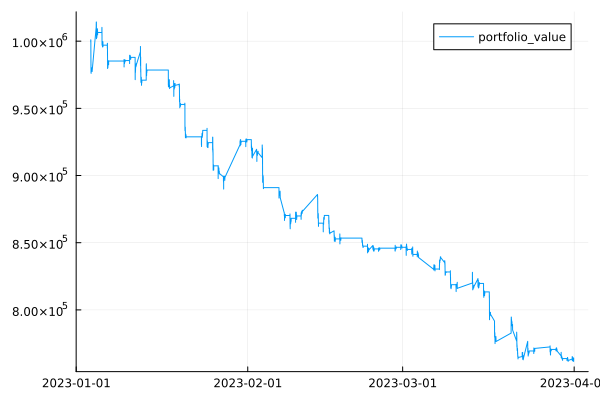

In [6]:
using Plots
plot(only_trading(TimeArray(trader)[:portfolio_value]))

Again we see that this strategy does not particularly work.

## Invert
The interesting part is that our strategy is not just bad, it's **consistently bad**. This means that again,
we can invert it and theoretically get a **consistently good** strategy (big grains of salt here).
This can be achieved by inserting one line in the above `PairStrat`: `ticker1, ticker2 = ticker2, ticker1`.

In [7]:
function Overseer.update(s::PairStrat, m::Trading.Trader, ticker_ledgers)
    curt = current_time(m)
    if Trading.is_market_open(curt)
        reset!(ticker_ledgers[end], s)
    end

    !in_day(curt) && return

    cash = m[Trading.PurchasePower][1].cash
    new_pos = any(x -> x ∉ m[Trading.Order], @entities_in(m, Purchase || Sale))

    ticker1 = ticker_ledgers[1].ticker
    ticker2 = ticker_ledgers[2].ticker

    γ = s.γ[dayofweek(curt)]
    z_comp = ticker_ledgers[end][ZScore{Spread}]

    for e in new_entities(ticker_ledgers[end], s)

        v         = e.v
        sma       = e.sma
        σ         = e.σ
        z_score   = (v - sma) / σ
        ticker_ledgers[end][e] = ZScore{Spread}(z_score)
        new_pos && continue

        ticker1, ticker2 = ticker2, ticker1

        curpos1 = current_position(m, ticker1)
        curpos2 = current_position(m, ticker2)

        p1 = current_price(m, ticker1)
        p2 = current_price(m, ticker2)

        quantity2(n1) = round(Int, n1 * p1 * γ / p2)

        in_bought_leg = curpos1 > 0
        in_sold_leg = curpos1 < 0

        if z_score < -s.z_thr&& (in_sold_leg || curpos1 == 0)
            new_pos = true
            if in_sold_leg
                q = -2*curpos1
            else
                q = cash/p1
            end
            Entity(m, Purchase(ticker1, round(Int, q)))
            Entity(m, Sale(ticker2, quantity2(q)))


        elseif z_score > s.z_thr && (in_bought_leg || curpos1 == 0)
            new_pos = true
            if in_bought_leg
                q = 2*curpos1
            else
                q = cash / p1
            end
            Entity(m, Purchase(ticker2, quantity2(q)))
            Entity(m, Sale(ticker1, round(Int, q)))
        end

        prev_e = prev(e, 1)
        prev_e === nothing && continue

        if new_pos || prev_e ∉ z_comp
            continue
        end
        going_up = z_score - z_comp[prev_e].v > 0
        if z_score > 0 && in_bought_leg && !going_up
            Entity(m, Sale(ticker1, curpos1))
            Entity(m, Purchase(ticker2, -curpos2))
            new_pos = true
        elseif z_score < 0 && in_sold_leg && going_up
            Entity(m, Purchase(ticker1, -curpos1))
            Entity(m, Sale(ticker2, curpos2))
            new_pos = true
        end
    end
end

We reset the trader, and check our results (see `Trading.relative`):

⠋ Simulating... 	 Time: 0:00:01
  t:      2023-01-03T14:31:00
⠙ Simulating... 	 Time: 0:00:02
  t:      2023-01-18T17:52:00
⠹ Simulating... 	 Time: 0:00:03
  t:      2023-01-31T18:59:00
⠸ Simulating... 	 Time: 0:00:04
  t:      2023-02-10T15:51:00
⠼ Simulating... 	 Time: 0:00:05
  t:      2023-02-20T17:48:00
⠴ Simulating... 	 Time: 0:00:06
  t:      2023-02-28T16:51:00
⠦ Simulating... 	 Time: 0:00:07
  t:      2023-03-07T19:24:00
⠧ Simulating... 	 Time: 0:00:08
  t:      2023-03-14T19:03:00
⠇ Simulating... 	 Time: 0:00:09
  t:      2023-03-21T16:23:00
⠏ Simulating... 	 Time: 0:00:10
  t:      2023-03-27T19:32:00
⠋ Simulating... 	 Time: 0:00:11
  t:      2023-03-31T20:51:00
  value:  1.36988179941666e6[ Info: Closed Trading Stream
[ Info: Issue with data stream, restarting
✓ Simulating... 	 Time: 0:00:14


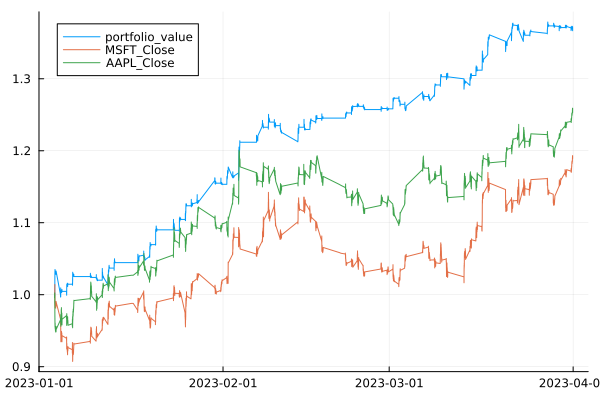

In [8]:
reset!(trader)
start(trader)

ta = Trading.relative(only_trading(TimeArray(trader)))
to_plot = merge(ta[:portfolio_value], Trading.relative(rename(bars(broker, "MSFT", sim_start, sim_stop, timeframe=Minute(1))[:c], :MSFT_Close)),
                    Trading.relative(rename(bars(broker, "AAPL", sim_start, sim_stop, timeframe=Minute(1))[:c], :AAPL_Close)))

plot(to_plot)

Behold, a seemingly succesful strategy.

## Performance analysis

See Performance Analysis

In [9]:
using Trading.Analysis

println("""
sharpe:           $(sharpe(trader))
downside_risk:    $(downside_risk(trader))
value_at_risk:    $(value_at_risk(trader))
maximum_drawdown: $(maximum_drawdown(trader))
"""
);

sharpe:           0.4700558295206738
downside_risk:    0.01193056883857176
value_at_risk:    -0.006594468076949317
maximum_drawdown: 0.03700608580708509

